In [128]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

ssps = ['SSP{}'.format(i) for i in range(1, 6)]

# Regional Mappings

In [129]:
# apply region mapping
mapping = pd.read_csv('region_mapping.csv').set_index('cntry_code')
regions = sorted(set(mapping.wbregion2.dropna()))
palette = sns.color_palette(sns.hls_palette(n_colors=len(regions), l=.4))
region_colors = {r: palette.pop() for r in regions}

# Projected Values

In [130]:
# inc and ineq
pdf = pd.read_csv('../econ/nbs/data/projections_ur_income.csv', index_col=[0, 1])
#pdf = pdf.loc[['SSP1', 'SSP4']][['iso', 'gdppc']].reset_index()
pdf = pdf[['iso', 'gdppc']].reset_index()
pdf = pdf[pdf.year <= 2050]
pdf.head()

,scenario,year,iso,gdppc
0,SSP1,2015,AFG,1458.111510
1,SSP1,2020,AFG,1618.827816
2,SSP1,2025,AFG,1942.845458
3,SSP1,2030,AFG,2486.587835
4,SSP1,2035,AFG,3304.317900


In [131]:
# std of ineq
sdf = pd.read_csv('adjusted_multi_single.csv') # result of smooth.ipynb
sdf.columns = ['scenario'] + list(sdf.columns[1:])
sdf.columns.name = 'iso'

sdf = sdf[sdf.scenario.str.startswith(('mSSP', 'std'))]
sdf.scenario = sdf.scenario.apply(lambda x: x[1:] if x[0] == 'm' else x)
sdf = sdf.set_index(['scenario', 'year']).stack().reset_index()
#sdf = sdf[(sdf.scenario.isin(['SSP1', 'SSP4', 'std']))]

sdf = sdf.set_index(['scenario', 'year', 'iso'])
std = sdf.loc['std']
sdf['std'] = np.nan
for ssp in ssps:
    sdf.loc[ssp]['std'] = std
sdf.columns = ['gini', 'std']
sdf = sdf.drop('std')
sdf['var'] = sdf['std'] ** 2

sdf = sdf.reset_index()

ginis = sdf.copy() # save them for a later graph

sdf.head()

,scenario,year,iso,gini,std,var
0,SSP1,2011,AUT,26.106634,12.422885,154.328072
1,SSP1,2011,BEL,27.500149,11.115264,123.549094
2,SSP1,2011,BGR,36.457249,11.710701,137.140518
3,SSP1,2011,BLR,36.966496,12.616134,159.166837
4,SSP1,2011,BOL,54.783241,10.866814,118.087647


In [132]:
# reduce
pdf = pdf[pdf.iso.isin(sdf.iso)]
sdf = sdf[sdf.year.isin(pdf.year)]

In [133]:
pdf.head()

,scenario,year,iso,gdppc
162,SSP1,2015,BOL,5653.073693
163,SSP1,2020,BOL,6787.740537
164,SSP1,2025,BOL,8542.400946
165,SSP1,2030,BOL,11038.031604
166,SSP1,2035,BOL,14296.310137


In [134]:
# combine
proj = sdf.set_index(['scenario', 'iso', 'year']).sort_index()
p = pdf.set_index(['scenario', 'iso', 'year']).sort_index()
proj['gdppc'] = p

proj = proj.reset_index()
proj.head()

,scenario,iso,year,gini,std,var,gdppc
0,SSP1,AUT,2015,26.822889,12.513879,156.597168,44465.407084
1,SSP1,AUT,2020,27.286419,12.618526,159.227198,47874.461666
2,SSP1,AUT,2025,27.477064,12.769838,163.068763,51148.215662
3,SSP1,AUT,2030,27.515633,12.988577,168.703132,54773.374098
4,SSP1,AUT,2035,27.395164,13.270892,176.116574,58834.424443


# Historical Values

In [135]:
hist = pd.read_csv('Hist_GDP_Gini_Data.csv')
hist.columns = ['iso', 'year', 'gini', 'gdppc']
hist = hist[hist.year >= 2000]
hist = hist[hist.iso.isin(set(proj.iso))]
hist = hist.groupby(['iso', 'year']).median()
hist = hist.interpolate()
hist = hist.reset_index()
hist = hist[hist.year <= 2010]
hist[hist.iso == 'BRA'].head(10)

,iso,year,gini,gdppc
95,BRA,2000,56.75,7909.257055
96,BRA,2001,57.00,7902.181386
97,BRA,2002,57.00,8002.924570
98,BRA,2003,56.00,7990.241651
99,BRA,2004,55.00,8343.882110
100,BRA,2005,53.34,8509.430266
101,BRA,2006,51.68,8753.239343
102,BRA,2007,50.02,9196.765101
103,BRA,2008,48.36,9584.049380
104,BRA,2009,46.70,9468.388584


# Regional Aggregation

In [136]:
proj = proj.reset_index()
proj['region'] = proj.iso.apply(lambda i: mapping.loc[i])
hist['region'] = hist.iso.apply(lambda i: mapping.loc[i])
ginis['region'] = ginis.iso.apply(lambda i: mapping.loc[i])

def reg_clean(df):
    rm = ['Middle East & North Africa', 'South Asia']
    df.loc[df.iso == 'IND', 'region'] = 'Eastern Asia & the Pacific'
    df = df.drop(df[df.region.isin(rm)].region.index)
    return df

proj = reg_clean(proj)
hist = reg_clean(hist)
ginis = reg_clean(ginis)

In [137]:
grp = proj.groupby(['scenario', 'region', 'year'])
rproj = grp[['gdppc', 'gini']].median()
rproj['std'] = grp['var'].mean() ** 0.5
rproj['gini_mean'] = grp['gini'].mean()
rproj.head()

gdppc       gini        std  \
scenario region             year                                       
SSP1     Advanced Economies 2015  35867.774476  28.321433  11.759613   
                            2020  38703.034569  28.970358  12.014026   
                            2025  41699.249178  29.788711  12.298790   
                            2030  46170.688964  30.156304  12.632812   
                            2035  50939.044611  30.457971  13.012642   

                                  gini_mean  
scenario region             year             
SSP1     Advanced Economies 2015  30.026934  
                            2020  30.327887  
                            2025  30.526071  
                            2030  30.589147  
                            2035  30.512067

In [138]:
rhist = hist.groupby(['region', 'year']).median()
rhist['std'] = 0
rhist.head()

gini         gdppc  std
region             year                          
Advanced Economies 2000  29.50  27963.513200    0
                   2001  28.50  28367.782785    0
                   2002  28.88  28456.205215    0
                   2003  29.02  28733.695045    0
                   2004  28.00  29541.601990    0

# Plots

In [139]:
rdata = rproj.reset_index().set_index('scenario')
hdata = rhist.reset_index()

## 1 Figure per SSP

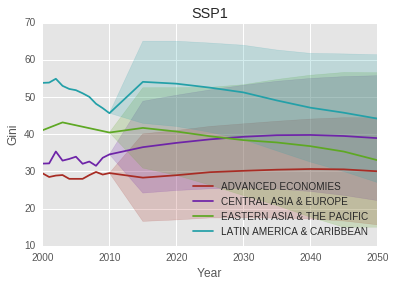

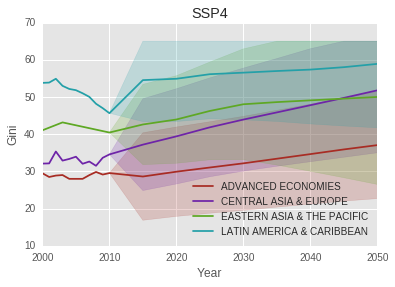

In [143]:
#x = 'gdppc'
#xlabel = 'GDP per Capita'
x = 'year'
xlabel = 'Year'

palette = sns.color_palette(sns.hls_palette(n_colors=4, l=.4))
colors = {i: palette.pop() for i in set(rhist.index.levels[0])}


for ssp in ['SSP1', 'SSP4']:
    df = pd.concat([rdata.loc[ssp], hdata])
    df = df.set_index('region')
    for reg in sorted(set(df.index)):
        data = df.loc[reg].sort_values(by=x)
        plt.plot(data[x], data.gini, label=reg.upper(), c=colors[reg])
        lb = (data.gini - data['std']).apply(lambda x: max(x, 15))
        ub = (data.gini + data['std']).apply(lambda x: min(x, 65))
        plt.fill_between(data[x], lb, ub, alpha=.2, color=colors[reg])
    plt.legend(loc='best')
    plt.xlabel(xlabel)
    plt.title(ssp)
    plt.ylabel('Gini')
    plt.show()
    plt.clf()